In [28]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

from tqdm import tqdm

def print_summary(df):
    display(df.info())
    display(df.head())

def calculate_combination_hiperparameters(param):
    total_combination_hiperparameters = 1
    for pages in param.values():
        total_combination_hiperparameters *= len(pages)
    return total_combination_hiperparameters

def assess_model_performance(model, name, X_train, y_train, cv):
    s = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)
    print('Performance of {}:\t{:0.1f} ± {:0.1f} %'.format( \
        name, s.mean().round(3)*100, s.std().round(3)*100))

def do_cross_val(model, X_train, y_train, n_splits=5):
    my_fold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train, y_train, cv=my_fold, n_jobs=-1, scoring='r2')
    return scores.mean(), scores.std()

In [3]:
# Usar si entrenamos desde Google Colab
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')
# This will prompt you to upload a file
uploaded = files.upload()

Mounted at /content/drive


Saving processed_train.csv to processed_train.csv


In [4]:
df = pd.read_csv('/content/processed_train.csv')
print_summary(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Elevation                           15120 non-null  float64
 1   Aspect                              15120 non-null  float64
 2   Slope                               15120 non-null  float64
 3   Horizontal_Distance_To_Hydrology    15120 non-null  float64
 4   Vertical_Distance_To_Hydrology      15120 non-null  float64
 5   Horizontal_Distance_To_Roadways     15120 non-null  float64
 6   Hillshade_9am                       15120 non-null  float64
 7   Hillshade_Noon                      15120 non-null  float64
 8   Hillshade_3pm                       15120 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  15120 non-null  float64
 10  Wilderness_Area1                    15120 non-null  float64
 11  Wilderness_Area2                    15120

None

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,-0.367095,-0.959980,-1.597132,0.146639,-0.834074,-0.908681,0.271454,0.571653,0.281259,4.334805,...,0,0,0,0,0,0,0,0,0,5
1,-0.381461,-0.914559,-1.715424,-0.072337,-0.932054,-0.999246,0.238732,0.703225,0.346627,4.285710,...,0,0,0,0,0,0,0,0,0,5
2,0.130912,-0.160577,-0.887379,0.194243,0.227369,1.106379,0.696843,0.834797,-0.002005,4.191156,...,0,0,0,0,0,0,0,0,0,2
3,0.085421,-0.015231,0.177250,0.070474,1.092853,1.038455,0.827731,0.834797,-0.285268,4.272981,...,0,0,0,0,0,0,0,0,0,2
4,-0.369489,-1.014485,-1.715424,-0.353198,-0.850404,-0.998491,0.238732,0.659368,0.324838,4.237524,...,0,0,0,0,0,0,0,0,0,5


Train y Test

In [17]:
X = df.drop("Cover_Type",axis=1)
y = df["Cover_Type"]

# Separar el 20% de los datos para pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37, shuffle=True)

Instance del modelo RandomForest

In [19]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=1, n_estimators=70)

Entrenamiento preliminar

In [20]:
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)
assess_model_performance(rf_model,"Random Forest", X_train, y_train, cv)

Performance of Random Forest:	84.4 ± 0.4 %


Tratamos de mejorar ese rendimiento haciendo una GridSearch en los hiperparámetros

In [23]:
param_trees = {'n_estimators': [50, 60, 70],
               'max_depth': [5, 10, 30, 40],
               'min_samples_leaf':[1]}

total_combination_hiperparameters = calculate_combination_hiperparameters(param_trees)
total_combination_hiperparameters

12

In [24]:
# Crear el GridSearchCV con tqdm
with tqdm(total=total_combination_hiperparameters) as pbar:
    grid_search = GridSearchCV(rf_model, param_grid=param_trees, cv=cv, verbose=3, n_jobs=3)

    # Ajustar el modelo y actualizar la barra de progreso
    grid_search.fit(X, y)

    pbar.update(1)  # Esto puede no ser necesario, ya que verbose ya muestra el progreso

  0%|          | 0/12 [00:00<?, ?it/s]

Fitting 3 folds for each of 12 candidates, totalling 36 fits


  8%|▊         | 1/12 [00:38<07:07, 38.89s/it]


In [25]:
grid_search.best_estimator_

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_*100)

Mejores hiperparámetros: {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 70}
Mejor puntuación: 84.97354497354496


In [27]:
print("Mejores hiperparámetros:", grid_search.best_params_)

# Predecir en el conjunto de prueba con el mejor modelo
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
# Evaluar el rendimiento
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f"Accuracy en el conjunto de entrenamiento: {accuracy_train*100}")

y_test_pred = best_model.predict(X_test)
# Evaluar el rendimiento
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy en el conjunto de prueba: {accuracy_test*100}")

Mejores hiperparámetros: {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 70}
Accuracy en el conjunto de entrenamiento: 99.9917328042328
Accuracy en el conjunto de prueba: 100.0


In [29]:
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

[[430   0   0   0   0   0   0]
 [  0 435   0   0   0   0   0]
 [  0   0 425   0   0   0   0]
 [  0   0   0 429   0   0   0]
 [  0   0   0   0 401   0   0]
 [  0   0   0   0   0 444   0]
 [  0   0   0   0   0   0 460]]


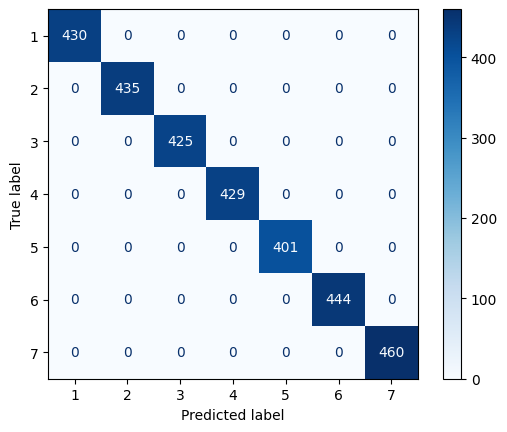

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')

Guardado del Modelo

In [ ]:
# Guardo el modelo en formato h5
with open('random_forest_model.h5', 'wb') as f:
    pickle.dump(best_model, f)

# Cargo el modelo para ver si lo hizo bien
with open('random_forest_model.h5', 'rb') as f:
    clf_loaded = pickle.load(f)
